## Multiclass Classification

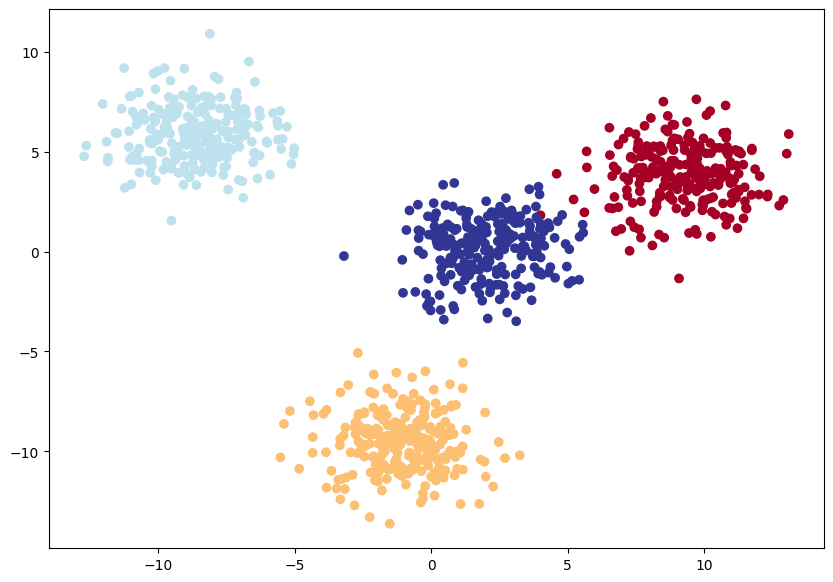

In [34]:
# Import Deps
import torch
import torchmetrics
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Hyper Parameters
NUM_CLASSES =  4
NUM_FEATURES = 2
RANDOM_SEED = 8888

# Multi-Class Data
X_blob, y_blob = make_blobs(
    n_samples=1000, 
    n_features=NUM_FEATURES, 
    centers=NUM_CLASSES, 
    cluster_std=1.5, 
    random_state=RANDOM_SEED)

# Convert Data to Tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_blob, 
    y_blob, 
    test_size=0.2, 
    random_state=RANDOM_SEED)

# Plot Data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [35]:
X_train.shape, y_train[:5]

(torch.Size([800, 2]), tensor([3, 2, 3, 2, 1]))

In [36]:
# Set Device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Multi-Class Classification Model
class BlobModel(torch.nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = torch.nn.Sequential(
            torch.nn.Linear(in_features=input_features, out_features=hidden_units),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=hidden_units, out_features=hidden_units),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)
    
# Create Model Instance
model_4 = BlobModel(input_features=2, output_features=4, hidden_units=8).to(device)

# Cross Entropy Loss (Multi-Class Specific)
loss_fn = torch.nn.CrossEntropyLoss()

# Stochastic Gradient Descent Optimizer
optimizer = torch.optim.SGD(
    params=model_4.parameters(), 
    lr=0.1)

# Model Hyperparameters
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
EPOCHS = 200

# Send Data to Device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop Through Data
for EPOCH in range(EPOCHS):
    #Train Model
    model_4.train()
    
    y_logits = model_4(X_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    
    loss = loss_fn(y_logits, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #Test Model
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
        
        test_loss = loss_fn(test_logits, y_test)

    if EPOCH % 20 == 0:
        print(f"Epoch: {EPOCH} | Loss: {loss}, Test Loss: {test_loss}")

Epoch: 0 | Loss: 1.819063425064087, Test Loss: 1.218072772026062
Epoch: 20 | Loss: 0.484893262386322, Test Loss: 0.4802837371826172
Epoch: 40 | Loss: 0.2495105117559433, Test Loss: 0.25764554738998413
Epoch: 60 | Loss: 0.17622484266757965, Test Loss: 0.18806564807891846
Epoch: 80 | Loss: 0.13691379129886627, Test Loss: 0.1486915796995163
Epoch: 100 | Loss: 0.10902328789234161, Test Loss: 0.12016753852367401
Epoch: 120 | Loss: 0.08895512670278549, Test Loss: 0.09930790960788727
Epoch: 140 | Loss: 0.07436136156320572, Test Loss: 0.08366860449314117
Epoch: 160 | Loss: 0.06357484310865402, Test Loss: 0.071719229221344
Epoch: 180 | Loss: 0.05530659854412079, Test Loss: 0.06231914460659027


In [37]:
# Make Predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_test)
    
y_logits[:10]

tensor([[ -3.7536,  -1.7525,   9.3430,   3.6468],
        [  1.6171,  -3.4608,  -3.3136,   4.3768],
        [ 14.7959, -12.5542, -10.6127,   9.6703],
        [ -1.7626,   4.5605,  -1.7751,  -0.8435],
        [ -1.5740,   3.4767,  -1.4156,  -0.3523],
        [ -1.9055,   5.3867,  -2.0502,  -1.2175],
        [ -3.8034,  -1.6651,   9.5696,   3.5314],
        [ 14.5507, -12.1520, -10.2625,   9.3312],
        [ -0.3187,  -2.1352,  -2.2281,   3.6153],
        [ -1.4501,   0.9522,  -0.6752,   0.9424]], device='cuda:0')

In [38]:
# Go from Logits => Prediction Probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[2.0452e-06, 1.5130e-05, 9.9664e-01, 3.3474e-03],
        [5.9492e-02, 3.7082e-04, 4.2961e-04, 9.3971e-01],
        [9.9409e-01, 1.3165e-12, 9.1755e-12, 5.9080e-03],
        [1.7800e-03, 9.9200e-01, 1.7580e-03, 4.4628e-03],
        [6.1846e-03, 9.6558e-01, 7.2460e-03, 2.0984e-02],
        [6.7902e-04, 9.9738e-01, 5.8753e-04, 1.3512e-03],
        [1.5528e-06, 1.3175e-05, 9.9761e-01, 2.3800e-03],
        [9.9462e-01, 2.5168e-12, 1.6651e-11, 5.3808e-03],
        [1.9076e-02, 3.1016e-03, 2.8265e-03, 9.7500e-01],
        [3.9745e-02, 4.3914e-01, 8.6265e-02, 4.3485e-01]], device='cuda:0')

In [39]:
# Go from Prediction Probabilities to Prediciton Labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([2, 3, 0, 1, 1, 1, 2, 0, 3, 1], device='cuda:0')

In [40]:
y_test

tensor([2, 3, 0, 1, 1, 1, 2, 0, 3, 3, 1, 3, 3, 2, 1, 2, 3, 2, 3, 1, 0, 3, 2, 0,
        3, 3, 1, 2, 0, 3, 0, 0, 1, 0, 3, 0, 1, 1, 2, 1, 1, 2, 2, 0, 2, 2, 0, 2,
        0, 0, 0, 0, 1, 0, 2, 1, 1, 0, 3, 3, 2, 2, 1, 3, 0, 3, 2, 2, 0, 1, 1, 3,
        0, 1, 3, 0, 1, 2, 1, 3, 1, 0, 0, 1, 3, 0, 2, 1, 1, 3, 2, 3, 1, 1, 3, 1,
        0, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 3, 0, 1, 0, 3, 0, 1, 0, 1, 3, 2, 0,
        3, 3, 1, 3, 3, 3, 1, 1, 1, 3, 3, 3, 1, 0, 0, 1, 0, 0, 3, 2, 2, 2, 2, 1,
        3, 1, 0, 1, 0, 1, 0, 3, 1, 3, 2, 2, 3, 1, 1, 0, 0, 0, 2, 3, 0, 3, 0, 1,
        3, 1, 0, 1, 2, 0, 2, 2, 0, 1, 0, 0, 0, 0, 3, 3, 2, 2, 2, 2, 2, 1, 2, 3,
        0, 2, 3, 2, 1, 3, 2, 0], device='cuda:0')

In [41]:
# Visualize the training model's performance against the test set
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.title("Train")
# plot_decision_boundary(model_4, X_train, y_train)
# plt.subplot(1, 2, 2)
# plt.title("Test")
# plot_decision_boundary(model_4, X_test, y_test)

### Classification Metrics

Requires `torchmetrics`

#### Accuracy

`torchmetrics.Accuracy()`
Not good for imbalanced dataset classes, but good default for classification problems.

In [56]:
# Init metric
metric = torchmetrics.Accuracy().to(device)

# Check accuracy of label predictions
metric(y_preds, y_test)

tensor(0.9800, device='cuda:0')

#### Precision

`torchmetrics.Precision()`
High precion means less false positives, better for imbalanced sets.

#### Recall

`torchmetrics.Recall()`
High recall means less false negatives, better for imbalanced sets.

#### F1 Score

`torchmetrics.F1Score()`
A combination of Precision and Recal, good overall metrics for classification model.

#### Confusion Matrix

`torchmetrics.ConfusionMetrix()`
Good for comparing predictions to truth labels to see where the model gets confused. Not ideal for large numbers of classes.

#### Classification Report

`sklearn.metrics.classification_report`
Combines all the above metrics.